

# The Effects of Household Credit Market Conditions on Life Satisfaction in the Euro Area (2004–2021)

In [1]:
# FINAL ANALYSIS SCRIPT

# TABLE OF CONTENTS

# 0. SETUP: Libraries and general settings

# 1. DATA IMPORT AND PREPARATION
# 1.1 Eurobarometer Survey: Life Satisfaction
#   - Load and filter raw Eurobarometer data
#   - Select relevant countries and variables
#   - Define satisfaction dummy (1 if satislife ∈ [1, 2]); aggregate by country-year and compute logit-transformed satisfaction share
# - Mapping country names
# - Descriptive statistics of logit transformed life satisfaction by country
#   - Example logit transformed variable (Germany, 2010)

# 1.2 ECB Bank Lending Survey: Loan Demand and Credit Standards
#   - Load credit standards and loan demand data (ECB national files)
#   - Reshape data to long format and standardize quarter date format
#   - Merge ECB datasets by country and quarter_year
#   -Descriptive statistics o credit standards and loan demand in %
#   - Merge ECB data with Eurobarometer satisfaction data
#   - Filter final sample period (2004–2021)
#  - Visualization per counry density plots loan demand
#  -Visualization per counry density plots credit standards


# 2. MACROECONOMIC CONTROL VARIABLES
# - Load and prepare to merge
# - Merge control variables into panel dataset

# 3. OLS baseline and macro model (without intercept)

# 4. Robustness checks for baseline and macro model (without intercept)

# 5. Descriptive statistics of lagged macroeconomic control variables


# 0. SETUP: Libraries and general settings

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson, jarque_bera
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import StandardScaler
from functools import reduce
from IPython.display import display, Markdown

# definitions for plots
plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 12,
    'text.color': 'black',
    'axes.labelcolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black',
    'axes.edgecolor': 'black'
})

# 1. DATA IMPORT AND PREPARATION

# 1.1 Eurobarometer Survey: Life Satisfaction
#   - Load and filter raw Eurobarometer data


In [3]:
df = pd.read_stata("/Users/imkeborgstadt/Desktop/5. Semester/Bachelorarbeit/Eurobarometer/harmonised_EB_2004-2021_v3-0-0 3.dta", convert_categoricals=False)
df.head()

,year,ebid,studid,respidza,edid,respid,intdate_start,intdate_end,intdate,intday,...,val_8,val_9,val_10,val_11,val_12,val_13,val_14,lr,voteprob_sc,voteprob_nat_sc
0,2004.0,610.0,4056.0,105232.0,1.0.1 (2012-03-30),1.0,20040220.0,20040328.0,21.0,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,1.0
1,2004.0,610.0,4056.0,105233.0,1.0.1 (2012-03-30),2.0,20040220.0,20040328.0,25.0,25.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,1.0,1.0
2,2004.0,610.0,4056.0,105177.0,1.0.1 (2012-03-30),3.0,20040220.0,20040328.0,23.0,23.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,10.0,10.0
3,2004.0,610.0,4056.0,105176.0,1.0.1 (2012-03-30),4.0,20040220.0,20040328.0,24.0,24.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,1.0,1.0
4,2004.0,610.0,4056.0,105239.0,1.0.1 (2012-03-30),5.0,20040220.0,20040328.0,24.0,24.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,10.0,10.0


In [4]:
# quick dataframe check
df1 = df.copy()
df1.head()

,year,ebid,studid,respidza,edid,respid,intdate_start,intdate_end,intdate,intday,...,val_8,val_9,val_10,val_11,val_12,val_13,val_14,lr,voteprob_sc,voteprob_nat_sc
0,2004.0,610.0,4056.0,105232.0,1.0.1 (2012-03-30),1.0,20040220.0,20040328.0,21.0,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,1.0
1,2004.0,610.0,4056.0,105233.0,1.0.1 (2012-03-30),2.0,20040220.0,20040328.0,25.0,25.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,1.0,1.0
2,2004.0,610.0,4056.0,105177.0,1.0.1 (2012-03-30),3.0,20040220.0,20040328.0,23.0,23.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,10.0,10.0
3,2004.0,610.0,4056.0,105176.0,1.0.1 (2012-03-30),4.0,20040220.0,20040328.0,24.0,24.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,1.0,1.0
4,2004.0,610.0,4056.0,105239.0,1.0.1 (2012-03-30),5.0,20040220.0,20040328.0,24.0,24.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,10.0,10.0


#   - Select relevant countries and variables

In [5]:
euro_country_codes = [
    1, 2, 3, 4, 5, 6, 8, 11, 12, 13,
    14, 16, 18, 19, 21, 23, 24, 25, 27, 28
]
euro_country_codes

[1, 2, 3, 4, 5, 6, 8, 11, 12, 13, 14, 16, 18, 19, 21, 23, 24, 25, 27, 28]

In [6]:
# filtering variables and countries

variables = [
    "year", "pernext5", "fina_hhnext_2", "w_all", "gender", "age",
    "income_q", "married", "educ", "educ_age", "children", "sizehh",
    "soclass", "treu", "satislife", "country"]

df_euro = df[df["country"].isin(euro_country_codes)]

needed_variables = [var for var in variables if var in df_euro.columns]

df_filtered = df_euro[needed_variables]

# - Define satisfaction dummy (1 if satislife ∈ [1, 2]); aggregate by country-year and compute logit-transformed satisfaction share

In [7]:
df_filtered = df_filtered.copy()

df_filtered["satis_dummy"] = df_filtered["satislife"].isin([1, 2]).astype(int)

agg_df = df_filtered.groupby(["country", "year"]).agg(
    share_satislife=("satis_dummy", "mean"),
    count=("satis_dummy", "size")
).reset_index()

epsilon = 1e-6
agg_df["logit_satislife"] = np.log(
    (agg_df["share_satislife"] + epsilon) / (1 - agg_df["share_satislife"] + epsilon)
)

agg_df["year"] = agg_df["year"].astype(int)
agg_df["quarter_year"] = agg_df["year"].astype(str)+ "Q2"

agg_df.head()

,country,year,share_satislife,count,logit_satislife,quarter_year
0,1.0,2004,0.410495,2039,-0.361917,2004Q2
1,1.0,2005,0.821376,2021,1.525691,2005Q2
2,1.0,2006,0.847558,2027,1.715569,2006Q2
3,1.0,2007,0.831625,2049,1.597185,2007Q2
4,1.0,2008,0.789066,2067,1.319303,2008Q2


# - Mapping country names

In [8]:
country_map = {
    1: "France",
    2: "Belgium",
    3: "Netherlands",
    4: "Germany",# West Germany
    5: "Italy",
    6: "Luxembourg",
    8: "Ireland",
    11: "Greece",
    12: "Spain",
    13: "Portugal",
    14: "Germany",# East Germany
    16: "Finland",
    18: "Austria",
    19: "Cyprus",
    21: "Estonia",
    23: "Latvia",
    24: "Lithuania",
    25: "Malta",
    27: "Slovakia",
    28: "Slovenia",
}


df_filtered["country"] = df_filtered["country"].map(country_map)
agg_df["country"] = agg_df["country"].map(country_map)

# - Descriptive statistics of logit transformed life satisfaction by country

In [9]:
desc_by_country = agg_df.groupby("country")["logit_satislife"].describe()

desc_by_country = desc_by_country.sort_index()

pd.set_option('display.max_rows', None)

print(desc_by_country)


             count      mean       std       min       25%       50%  \
country                                                                
Austria       18.0  1.561633  0.740488 -0.364346  1.530248  1.748301   
Belgium       18.0  1.913780  0.793120 -0.242878  2.038318  2.159025   
Cyprus        18.0  1.446254  0.571912 -0.673900  1.363644  1.577632   
Estonia       18.0  1.016323  0.498797 -0.654450  0.809108  1.087748   
Finland       18.0  2.420814  0.968195 -0.193826  2.655849  2.745945   
France        18.0  1.365072  0.638209 -0.361917  1.444177  1.581471   
Germany       36.0  1.543532  0.909025 -1.151253  1.110915  1.745223   
Greece        18.0 -0.148440  0.582675 -1.561018 -0.406718 -0.178481   
Ireland       18.0  2.056558  0.962257 -0.396752  1.949558  2.233121   
Italy         18.0  0.621095  0.524073 -0.842609  0.595977  0.677173   
Latvia        18.0  0.613535  0.496387 -0.733783  0.366462  0.587638   
Lithuania     18.0  0.497956  0.475416 -0.729325  0.197248  0.51

In [10]:
#quick data frame check
agg_df

,country,year,share_satislife,count,logit_satislife,quarter_year
0,France,2004,0.410495,2039,-0.361917,2004Q2
1,France,2005,0.821376,2021,1.525691,2005Q2
2,France,2006,0.847558,2027,1.715569,2006Q2
3,France,2007,0.831625,2049,1.597185,2007Q2
4,France,2008,0.789066,2067,1.319303,2008Q2
5,France,2009,0.809455,2073,1.446468,2009Q2
6,France,2010,0.826362,2056,1.560055,2010Q2
7,France,2011,0.800292,2053,1.388118,2011Q2
8,France,2012,0.850620,2015,1.739469,2012Q2
9,France,2013,0.412482,2051,-0.353715,2013Q2


#   - Example logit transformed variable (Germany, 2010)

In [11]:
if "year" in df_filtered.columns and "country" in df_filtered.columns and "satis_dummy" in df_filtered.columns:
 
    example = df_filtered[(df_filtered["country"] == "Germany") & (df_filtered["year"] == 2010)]

    if not example.empty:
  
        satisfaction_counts = example["satis_dummy"].value_counts().sort_index()


        total = satisfaction_counts.sum()
        satisfied = satisfaction_counts.get(1, 0)
        share = satisfied / total if total > 0 else float('nan')


        print("number satisfied (dummy=1):", satisfied)
        print("number unsatisfied (dummy=0):", satisfaction_counts.get(0, 0))
        print("total:", total)
        print("share satisfied (share_satislife):", round(share, 6))
    else:
        print("Keine Daten für Germany im Jahr 2010 gefunden.")
else:
    print("Benötigte Spalten ('year', 'country', 'satis_dummy') fehlen.")


number satisfied (dummy=1): 2603
number unsatisfied (dummy=0): 521
total: 3124
share satisfied (share_satislife): 0.833227


# 1.2 ECB Bank Lending Survey: Loan Demand and Credit Standards
#   - Load credit standards and loan demand data (ECB national files)

In [12]:
# Cedit Standard (CS)and Loan Demand (LD) Data per country

# Dateipfade für CS
file_paths_cs = {
    "Austria": "/Users/imkeborgstadt/Desktop/5. Semester/Bachelorarbeit/CS HH HC/Austria.xlsx",
    "Belgium": "/Users/imkeborgstadt/Desktop/5. Semester/Bachelorarbeit/CS HH HC/Belgium.xlsx", 
    "Cyprus": "/Users/imkeborgstadt/Desktop/5. Semester/Bachelorarbeit/CS HH HC/Cyprus.xlsx",
    "Estonia": "/Users/imkeborgstadt/Desktop/5. Semester/Bachelorarbeit/CS HH HC/Estonia.xlsx",
    "Finland": "/Users/imkeborgstadt/Desktop/5. Semester/Bachelorarbeit/CS HH HC/Finland.xlsx",
    "France": "/Users/imkeborgstadt/Desktop/5. Semester/Bachelorarbeit/CS HH HC/France.xlsx",
    "Germany": "/Users/imkeborgstadt/Desktop/5. Semester/Bachelorarbeit/CS HH HC/Germany.xlsx",
    "Greece": "/Users/imkeborgstadt/Desktop/5. Semester/Bachelorarbeit/CS HH HC/Greece.xlsx",
    "Ireland": "/Users/imkeborgstadt/Desktop/5. Semester/Bachelorarbeit/CS HH HC/Ireland.xlsx",
    "Italy": "/Users/imkeborgstadt/Desktop/5. Semester/Bachelorarbeit/CS HH HC/Italy.xlsx",
    "Latvia": "/Users/imkeborgstadt/Desktop/5. Semester/Bachelorarbeit/CS HH HC/Latvia.xlsx",
    "Lithuania": "/Users/imkeborgstadt/Desktop/5. Semester/Bachelorarbeit/CS HH HC/Lithunia.xlsx",
    "Luxembourg": "/Users/imkeborgstadt/Desktop/5. Semester/Bachelorarbeit/CS HH HC/Luxembourg.xlsx",
    "Malta": "/Users/imkeborgstadt/Desktop/5. Semester/Bachelorarbeit/CS HH HC/Malta.xlsx",
    "Netherlands": "/Users/imkeborgstadt/Desktop/5. Semester/Bachelorarbeit/CS HH HC/Netherlands.xlsx",
    "Portugal": "/Users/imkeborgstadt/Desktop/5. Semester/Bachelorarbeit/CS HH HC/Portugal.xlsx",
    "Slovakia": "/Users/imkeborgstadt/Desktop/5. Semester/Bachelorarbeit/CS HH HC/Slovakia.xlsx",
    "Slovenia": "/Users/imkeborgstadt/Desktop/5. Semester/Bachelorarbeit/CS HH HC/Slovenia.xlsx",
    "Spain": "/Users/imkeborgstadt/Desktop/5. Semester/Bachelorarbeit/CS HH HC/Spain.xlsx"
}

# Dateipfade für LD
file_paths_ld = {
    "France": "/Users/imkeborgstadt/Desktop/5. Semester/Bachelorarbeit/LD HH HC/France.xlsx",
    "Germany": "/Users/imkeborgstadt/Desktop/5. Semester/Bachelorarbeit/LD HH HC/Germany.xlsx",
    "Italy": "/Users/imkeborgstadt/Desktop/5. Semester/Bachelorarbeit/LD HH HC/Italy.xlsx",
    "Luxembourg": "/Users/imkeborgstadt/Desktop/5. Semester/Bachelorarbeit/LD HH HC/Luxembourg.xlsx",
    "Netherlands": "/Users/imkeborgstadt/Desktop/5. Semester/Bachelorarbeit/LD HH HC/Netherlands.xlsx",
    "Austria": "/Users/imkeborgstadt/Desktop/5. Semester/Bachelorarbeit/LD HH HC/Austria.xlsx",
    "Cyprus": "/Users/imkeborgstadt/Desktop/5. Semester/Bachelorarbeit/LD HH HC/Cyprus.xlsx",
    "Estonia": "/Users/imkeborgstadt/Desktop/5. Semester/Bachelorarbeit/LD HH HC/Estonia.xlsx",
    "Finland": "/Users/imkeborgstadt/Desktop/5. Semester/Bachelorarbeit/LD HH HC/Finland.xlsx",
    "Greece": "/Users/imkeborgstadt/Desktop/5. Semester/Bachelorarbeit/LD HH HC/Greece.xlsx",
    "Ireland": "/Users/imkeborgstadt/Desktop/5. Semester/Bachelorarbeit/LD HH HC/Ireland.xlsx",
    "Latvia": "/Users/imkeborgstadt/Desktop/5. Semester/Bachelorarbeit/LD HH HC/Latvia.xlsx",
    "Lithuania": "/Users/imkeborgstadt/Desktop/5. Semester/Bachelorarbeit/LD HH HC/Lithuania.xlsx",
    "Malta": "/Users/imkeborgstadt/Desktop/5. Semester/Bachelorarbeit/LD HH HC/Malta.xlsx",
    "Portugal": "/Users/imkeborgstadt/Desktop/5. Semester/Bachelorarbeit/LD HH HC/Portugal.xlsx",
    "Slovakia": "/Users/imkeborgstadt/Desktop/5. Semester/Bachelorarbeit/LD HH HC/Slovakia.xlsx",
    "Slovenia": "/Users/imkeborgstadt/Desktop/5. Semester/Bachelorarbeit/LD HH HC/Slovenia.xlsx",
    "Spain": "/Users/imkeborgstadt/Desktop/5. Semester/Bachelorarbeit/LD HH HC/Spain.xlsx",
    "Belgium": "/Users/imkeborgstadt/Desktop/5. Semester/Bachelorarbeit/LD HH HC/Belgium.xlsx"
}


dfs_cd = []
dfs_ld = []

for land, path in file_paths_cs.items():
    try:
        df = pd.read_excel(path, sheet_name="DATA", skiprows=0)
        df.columns = df.columns.str.strip()
        df = df[["DATE", df.columns[2]]].copy()
        df.columns = ["Date", land]
        df["Date"] = pd.to_datetime(df["Date"])
        dfs_cd.append(df)
    except Exception as e:
        print(f"Fehler beim Einlesen der CS-Daten für {land}: {e}")

for land, path in file_paths_ld.items():
    try:
        df = pd.read_excel(path, sheet_name="DATA", skiprows=0)
        df.columns = df.columns.str.strip()
        df = df[["DATE", df.columns[2]]].copy()
        df.columns = ["Date", land]
        df["Date"] = pd.to_datetime(df["Date"])
        dfs_ld.append(df)
    except Exception as e:
        print(f"Fehler beim Einlesen der LD-Daten für {land}: {e}")

df_CS = reduce(lambda left, right: pd.merge(left, right, on="Date", how="outer"), dfs_cd)
df_CS.sort_values("Date", inplace=True)
df_CS.reset_index(drop=True, inplace=True)

df_LD = reduce(lambda left, right: pd.merge(left, right, on="Date", how="outer"), dfs_ld)
df_LD.sort_values("Date", inplace=True)
df_LD.reset_index(drop=True, inplace=True)

print("Credit Standards (CS):")
print(df_CS.head())

print("\nLoan Demand (LD):")
print(df_LD.head())



Credit Standards (CS):
        Date  Austria  Belgium  Cyprus  Estonia  Finland  France  Germany  \
0 2003-01-01       20      -25     NaN      NaN      -38       0       20   
1 2003-04-01       10      -13     NaN      NaN      -38       4       13   
2 2003-07-01        0      -13     NaN      NaN        0       0       -7   
3 2003-10-01       10      -13     NaN      NaN        0      -4        3   
4 2004-01-01        0        0     NaN      NaN        0       0        6   

   Greece  Ireland  Italy  Latvia  Lithuania  Luxembourg  Malta  Netherlands  \
0       0      -13      7     NaN        NaN           0    NaN           17   
1       0        0      0     NaN        NaN           0    NaN            8   
2       0        0      0     NaN        NaN          17    NaN           25   
3       0        0      0     NaN        NaN           8    NaN           25   
4       0        0     -7     NaN        NaN           0    NaN           17   

   Portugal  Slovakia  Slovenia  

#   - Reshape data to long format and standardize quarter date format

In [13]:
df_CS_long = df_CS.melt(id_vars=["Date"], var_name="country", value_name="credit_standards")
df_CS_long['Date'] = pd.to_datetime(df_CS_long['Date'], errors='coerce')
df_CS_long['quarter_year'] = df_CS_long['Date'].dt.year.astype(str) + "Q" + df_CS_long['Date'].dt.quarter.astype(str)

df_LD_long = df_LD.melt(id_vars=["Date"], var_name="country", value_name="loan_demand")
df_LD_long['Date'] = pd.to_datetime(df_LD_long['Date'], errors='coerce')
df_LD_long['quarter_year'] = df_LD_long['Date'].dt.year.astype(str) + "Q" + df_LD_long['Date'].dt.quarter.astype(str)

#   - Merge ECB datasets by country and quarter_year

In [14]:
df_macro = pd.merge(
    df_LD_long[['country', 'quarter_year', 'loan_demand']],
    df_CS_long[['country', 'quarter_year', 'credit_standards']],
    on=['country', 'quarter_year'],
    how='outer')

df_macro['loan_demand_pct'] = df_macro['loan_demand'] / 100
df_macro['credit_standards_pct'] = df_macro['credit_standards'] / 100
df_macro

,country,quarter_year,loan_demand,credit_standards,loan_demand_pct,credit_standards_pct
0,France,2003Q1,36.00,0.00,0.3600,0.0000
1,France,2003Q2,25.00,4.00,0.2500,0.0400
2,France,2003Q3,42.00,0.00,0.4200,0.0000
3,France,2003Q4,42.00,-4.00,0.4200,-0.0400
4,France,2004Q1,46.00,0.00,0.4600,0.0000
5,France,2004Q2,21.00,0.00,0.2100,0.0000
6,France,2004Q3,38.00,-8.00,0.3800,-0.0800
7,France,2004Q4,25.00,0.00,0.2500,0.0000
8,France,2005Q1,8.00,0.00,0.0800,0.0000
9,France,2005Q2,17.00,-4.00,0.1700,-0.0400


# - Descriptive statistics o credit standards and loan demand in %

In [15]:
desc_stats_cs_ld = df_macro[["loan_demand", "credit_standards"]].describe(percentiles=[.25, .5, .75]).T

desc_stats_cs_ld = desc_stats_cs_ld.rename(columns={
    'count': 'N', 
    'mean': 'Mean', 
    'std': 'SD',
    'min': 'Min', 
    '50%': 'Median', 
    '75%': '75%', 
    'max': 'Max'
})

desc_stats_cs_ld = desc_stats_cs_ld[['N', 'Mean', 'SD', 'Min', 'Median', '75%', 'Max']]

desc_stats_cs_ld = desc_stats_cs_ld.round(4)

print("Deskriptive Statistik für Credit Standards und Loan Demand (in Prozent):\n")
print(desc_stats_cs_ld)


Deskriptive Statistik für Credit Standards und Loan Demand (in Prozent):

                       N    Mean       SD    Min  Median   75%    Max
loan_demand       1496.0  0.7884  27.4445 -100.0     0.0  17.0  100.0
credit_standards  1499.0  4.2798  15.0907  -75.0     0.0  10.0  100.0


In [16]:
print("agg_df:")
print(agg_df[['country', 'quarter_year']].drop_duplicates().head(5))

print("\ndf_macro:")
print(df_macro[['country', 'quarter_year']].drop_duplicates().head(5))


agg_df:
  country quarter_year
0  France       2004Q2
1  France       2005Q2
2  France       2006Q2
3  France       2007Q2
4  France       2008Q2

df_macro:
  country quarter_year
0  France       2003Q1
1  France       2003Q2
2  France       2003Q3
3  France       2003Q4
4  France       2004Q1


#   - Merge ECB data with Eurobarometer satisfaction data

In [17]:
df_model = pd.merge(
    agg_df,
    df_macro,
    on=['country', 'quarter_year'],
    how='left'
)

df_model

,country,year,share_satislife,count,logit_satislife,quarter_year,loan_demand,credit_standards,loan_demand_pct,credit_standards_pct
0,France,2004,0.410495,2039,-0.361917,2004Q2,21.00,0.00,0.2100,0.0000
1,France,2005,0.821376,2021,1.525691,2005Q2,17.00,-4.00,0.1700,-0.0400
2,France,2006,0.847558,2027,1.715569,2006Q2,4.00,0.00,0.0400,0.0000
3,France,2007,0.831625,2049,1.597185,2007Q2,-27.00,5.00,-0.2700,0.0500
4,France,2008,0.789066,2067,1.319303,2008Q2,-25.00,8.00,-0.2500,0.0800
5,France,2009,0.809455,2073,1.446468,2009Q2,-27.00,0.00,-0.2700,0.0000
6,France,2010,0.826362,2056,1.560055,2010Q2,15.00,0.00,0.1500,0.0000
7,France,2011,0.800292,2053,1.388118,2011Q2,-19.00,4.00,-0.1900,0.0400
8,France,2012,0.850620,2015,1.739469,2012Q2,-62.00,4.00,-0.6200,0.0400
9,France,2013,0.412482,2051,-0.353715,2013Q2,-12.00,4.00,-0.1200,0.0400


#   - Filter final sample period (2004–2021)

In [18]:
df_model["year"] = df_model["quarter_year"].str[:4].astype(int)
df_model = df_model[df_model["year"].between(2004, 2021)]

# - Visualization per counry density plots loan demand

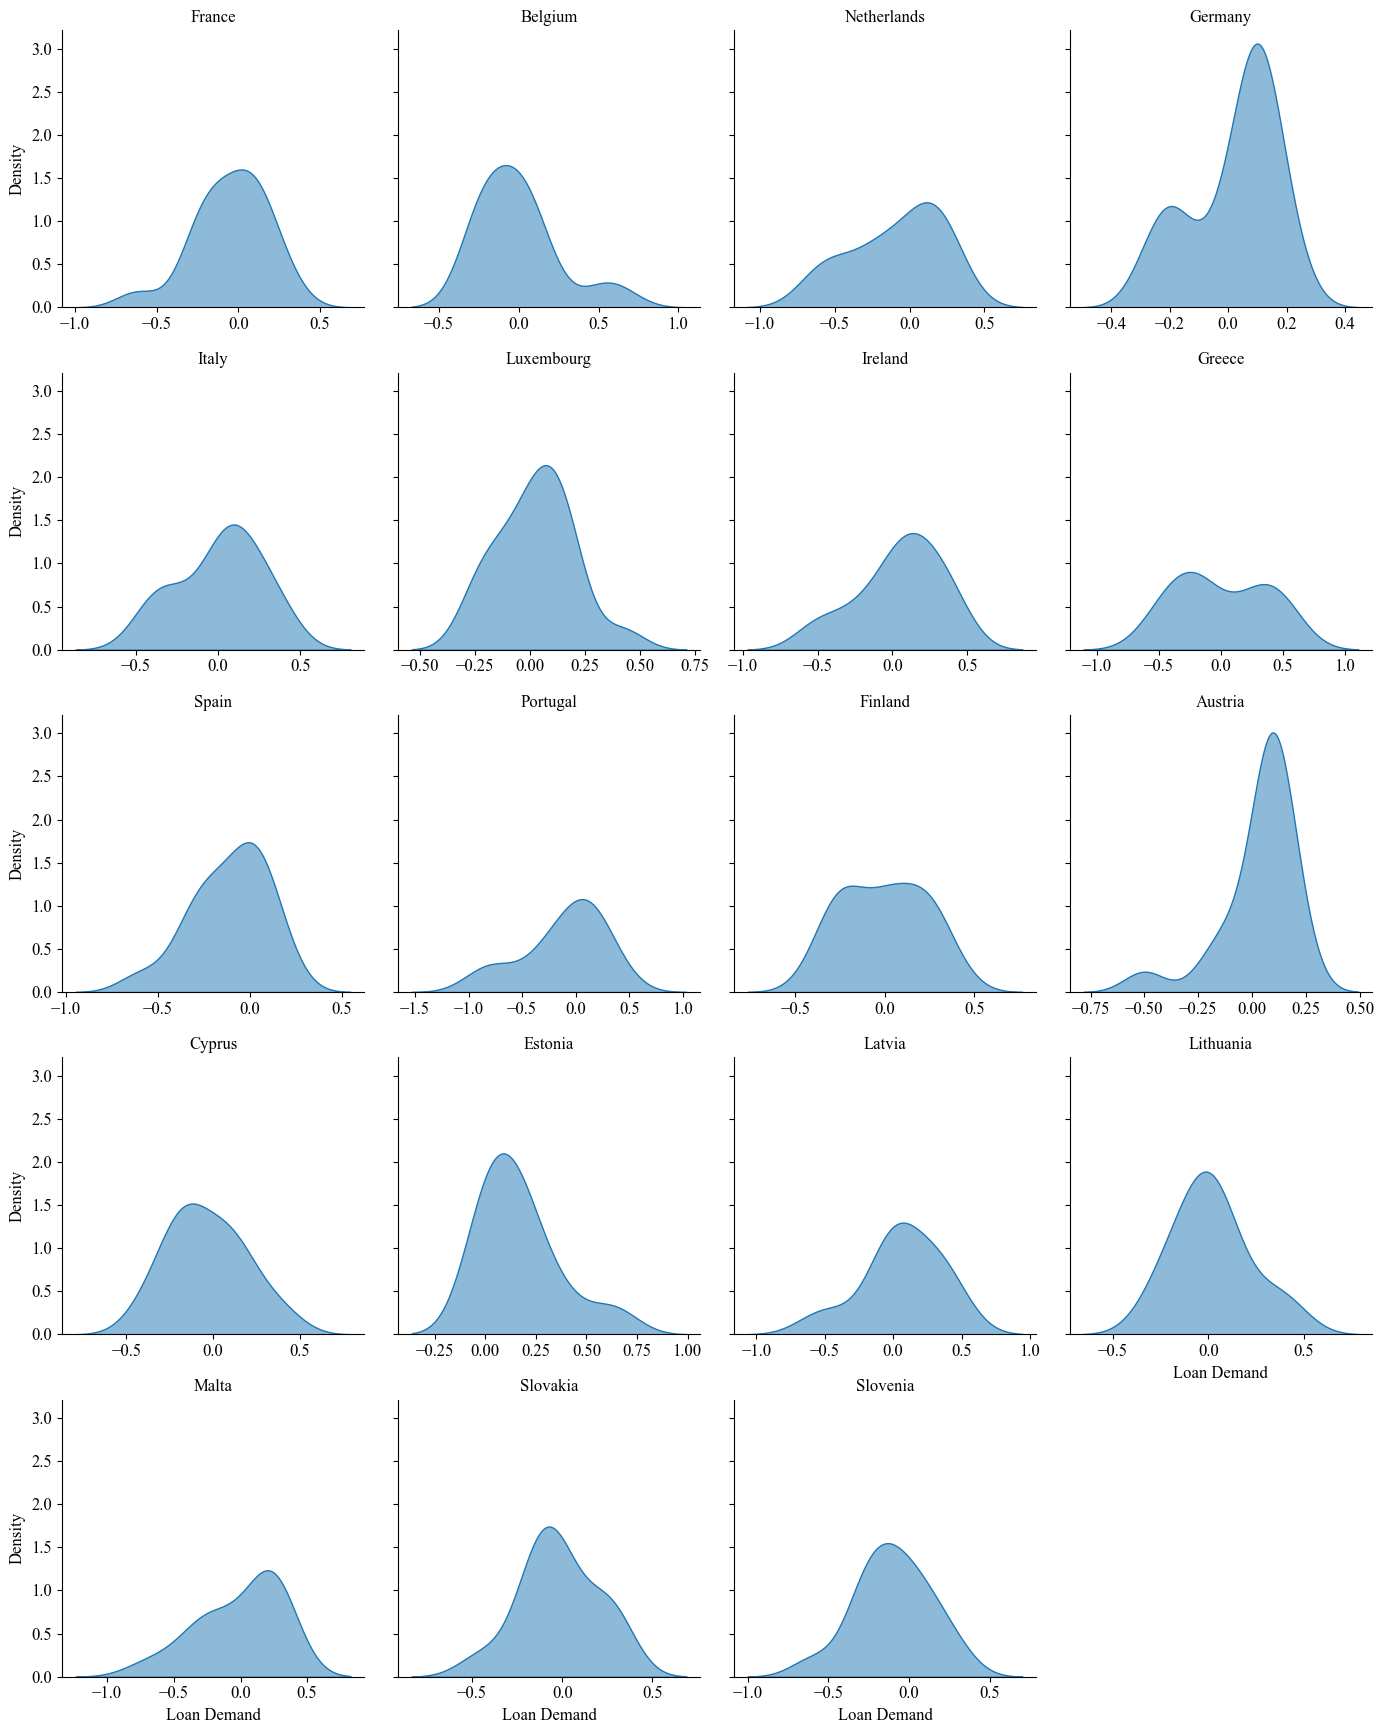

In [19]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12

g = sns.FacetGrid(df_model, col="country", col_wrap=4, height=3.5, sharex=False)
g.map_dataframe(sns.kdeplot, x="loan_demand_pct", fill=True, alpha=0.5)

g.set_titles(col_template="{col_name}")
g.set_axis_labels("Loan Demand", "Density")
plt.tight_layout()
plt.show()

# - Visualization per counry density plots credit standards

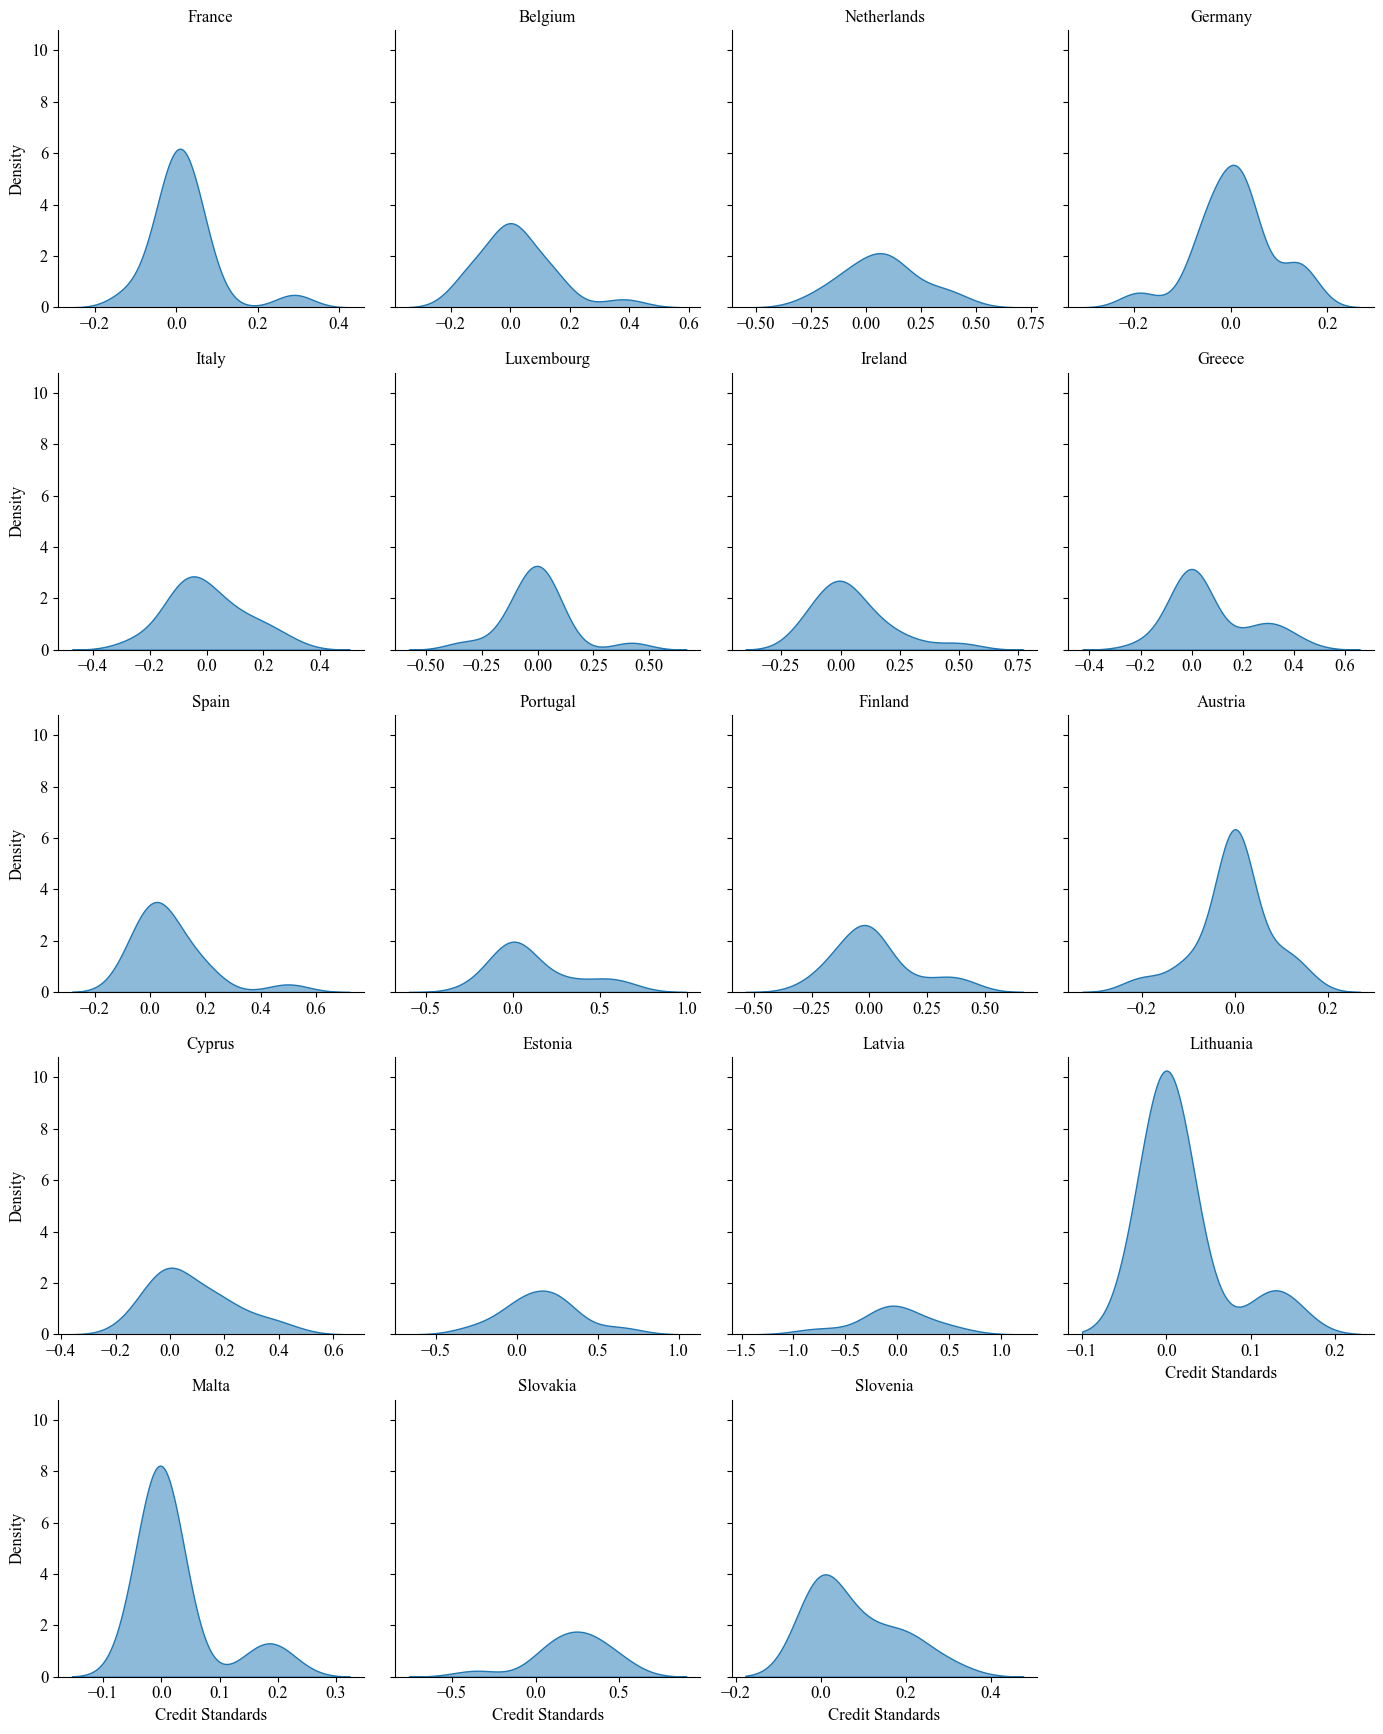

In [20]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12

g = sns.FacetGrid(df_model, col="country", col_wrap=4, height=3.5,sharex=False)
g.map_dataframe(sns.kdeplot, x="credit_standards_pct", fill=True, alpha=0.5)

g.set_titles(col_template="{col_name}")
g.set_axis_labels("Credit Standards", "Density")
plt.tight_layout()
plt.show()

# 2. MACROECONOMIC CONTROL VARIABLES(GDP per capita, Unemployment rate, HICP inflation)

# - Load and prepare to merge

In [21]:
hicp_df = pd.read_excel('/Users/imkeborgstadt/Desktop/5. Semester/Bachelorarbeit/GDP, Inflation, Unemployment/HICP - monthly data (annual rate of change).xlsx')
gdp_df = pd.read_excel('/Users/imkeborgstadt/Desktop/5. Semester/Bachelorarbeit/GDP, Inflation, Unemployment/Real GDP per capita .xlsx')
unemployment_df=pd.read_excel('/Users/imkeborgstadt/Desktop/5. Semester/Bachelorarbeit/GDP, Inflation, Unemployment/unemployment rate IMF.xlsx')

In [22]:
# transform from wide into long data formt and set index on quarterly frequency
hicp_long = hicp_df.melt(id_vars="TIME", var_name="month", value_name="hicp")
hicp_long.rename(columns={"TIME": "country"}, inplace=True)
hicp_long["month"] = pd.to_datetime(hicp_long["month"], format="%Y-%m", errors="coerce")
hicp_long = hicp_long.dropna(subset=["month"])
hicp_long["quarter_year"] = hicp_long["month"].dt.to_period("Q").astype(str)
hicp_quarterly = hicp_long.groupby(["country", "quarter_year"]).agg(hicp=("hicp", "mean")).reset_index()

gdp_long = gdp_df.melt(id_vars="TIME", var_name="year", value_name="gdp_per_capita")
gdp_long.rename(columns={"TIME": "country"}, inplace=True)
gdp_long["quarter_year"] = gdp_long["year"].astype(str) + "Q2"
gdp_long = gdp_long[["country", "quarter_year", "gdp_per_capita"]]

In [23]:
# assimilate country names
country_name_mapping = {
    "Netherlands, The": "Netherlands",
    "Estonia, Republic of": "Estonia",
    "Latvia, Republic of": "Latvia",
    "Lithuania, Republic of": "Lithuania",
    "Croatia, Republic of": "Croatia",  # optional weglassen, wenn du Croatia sowieso ausschließt
    "Slovenia, Republic of": "Slovenia",
    "Slovak Republic": "Slovakia"
}


unemployment_df["country"] = unemployment_df["COUNTRY"].replace(country_name_mapping)

unemployment_df["quarter_year"] = unemployment_df["TIME_PERIOD"].astype(str)


unemployment_df = unemployment_df.rename(columns={"OBS_VALUE": "unemployment_rate"})
unemployment_df = unemployment_df[["country", "quarter_year", "unemployment_rate"]]

unemployment_df["quarter_year"] = unemployment_df["quarter_year"].str.replace("-", "")
unemployment_df

,country,quarter_year,unemployment_rate
0,Greece,2004Q1,11.433333
1,Greece,2004Q2,10.300000
2,Greece,2004Q3,10.200000
3,Greece,2004Q4,10.500000
4,Greece,2005Q1,10.533333
5,Greece,2005Q2,9.766667
6,Greece,2005Q3,9.833333
7,Greece,2005Q4,9.900000
8,Greece,2006Q1,9.866667
9,Greece,2006Q2,8.900000


# - Merge control variables into panel dataset

In [24]:
df_model = df_model.merge(unemployment_df, on=["country", "quarter_year"], how="left")
df_model = df_model.merge(hicp_quarterly, on=["country", "quarter_year"], how="left")
df_model = df_model.merge(gdp_long, on=["country", "quarter_year"], how="left")

df_model

,country,year,share_satislife,count,logit_satislife,quarter_year,loan_demand,credit_standards,loan_demand_pct,credit_standards_pct,unemployment_rate,hicp,gdp_per_capita
0,France,2004,0.410495,2039,-0.361917,2004Q2,21.00,0.00,0.2100,0.0000,8.500000,2.633333,33300
1,France,2005,0.821376,2021,1.525691,2005Q2,17.00,-4.00,0.1700,-0.0400,8.533333,1.833333,33680
2,France,2006,0.847558,2027,1.715569,2006Q2,4.00,0.00,0.0400,0.0000,8.700000,2.166667,34360
3,France,2007,0.831625,2049,1.597185,2007Q2,-27.00,5.00,-0.2700,0.0500,7.866667,1.266667,35010
4,France,2008,0.789066,2067,1.319303,2008Q2,-25.00,8.00,-0.2500,0.0800,7.100000,3.700000,34960
5,France,2009,0.809455,2073,1.446468,2009Q2,-27.00,0.00,-0.2700,0.0000,8.933333,-0.266667,33800
6,France,2010,0.826362,2056,1.560055,2010Q2,15.00,0.00,0.1500,0.0000,9.033333,1.833333,34310
7,France,2011,0.800292,2053,1.388118,2011Q2,-19.00,4.00,-0.1900,0.0400,8.866667,2.233333,34990
8,France,2012,0.850620,2015,1.739469,2012Q2,-62.00,4.00,-0.6200,0.0400,9.400000,2.333333,34880
9,France,2013,0.412482,2051,-0.353715,2013Q2,-12.00,4.00,-0.1200,0.0400,10.133333,0.900000,34990


# 3. OLS baseline and macro model (without intercept)

In [25]:
df_model_lagged = df_model.copy()
df_model_lagged["loan_demand_pct_lag1"] = df_model_lagged.groupby("country")["loan_demand_pct"].shift(1)
df_model_lagged["credit_standards_pct_lag1"] = df_model_lagged.groupby("country")["credit_standards_pct"].shift(1)
df_model_lagged["unemployment_rate_lag1"] = df_model_lagged.groupby("country")["unemployment_rate"].shift(1)
df_model_lagged["hicp_lag1"] = df_model_lagged.groupby("country")["hicp"].shift(1)
df_model_lagged["gdp_per_capita_lag1"] = df_model_lagged.groupby("country")["gdp_per_capita"].shift(1)

df_model_lagged_clean = df_model_lagged.dropna(subset=[
    "logit_satislife", "loan_demand_pct_lag1", "credit_standards_pct_lag1",
    "unemployment_rate_lag1", "hicp_lag1", "gdp_per_capita_lag1"
]).copy()

# standardize
scaler = StandardScaler()
df_model_lagged_clean["loan_demand_lag_std"] = scaler.fit_transform(df_model_lagged_clean[["loan_demand_pct_lag1"]])
df_model_lagged_clean["credit_standards_lag_std"] = scaler.fit_transform(df_model_lagged_clean[["credit_standards_pct_lag1"]])

# Baseline w/o intercept
model_baseline_no_intercept = smf.ols(
    "logit_satislife ~ loan_demand_lag_std + credit_standards_lag_std + C(country) + C(quarter_year) - 1",
    data=df_model_lagged_clean
).fit()

print("Baseline Model (w/o Intercept):")
print(model_baseline_no_intercept.summary())

# Macro model w/o intercept
model_macro_no_intercept = smf.ols(
    """logit_satislife ~ loan_demand_lag_std + credit_standards_lag_std 
       + unemployment_rate_lag1 + hicp_lag1 + gdp_per_capita_lag1 
       + C(country) + C(quarter_year) - 1""",
    data=df_model_lagged_clean
).fit()

print("\nMacro-Model (w/o Intercept):")
print(model_macro_no_intercept.summary())

with open("Model_Baseline_noIntercept.txt", "w") as f:
    f.write(model_baseline_no_intercept.summary().as_text())

with open("Model_MacroControls_noIntercept.txt", "w") as f:
    f.write(model_macro_no_intercept.summary().as_text())

df_model_lagged_clean["yhat_baseline_no_intercept"] = model_baseline_no_intercept.fittedvalues
df_model_lagged_clean["yhat_macro_no_intercept"] = model_macro_no_intercept.fittedvalues

Baseline Model (w/o Intercept):
                            OLS Regression Results                            
Dep. Variable:        logit_satislife   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     69.93
Date:                Tue, 22 Jul 2025   Prob (F-statistic):          6.07e-114
Time:                        09:48:54   Log-Likelihood:                -73.230
No. Observations:                 297   AIC:                             222.5
Df Residuals:                     259   BIC:                             362.8
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

# 4. Robustness checks for baseline and macro model (without intercept)


Diagnostics for Macro Model

Robust Standard Errors (HC3):
                            OLS Regression Results                            
Dep. Variable:        logit_satislife   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 22 Jul 2025   Prob (F-statistic):                nan
Time:                        09:48:54   Log-Likelihood:                -50.680
No. Observations:                 297   AIC:                             183.4
Df Residuals:                     256   BIC:                             334.8
Df Model:                          40                                         
Covariance Type:                  HC3                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

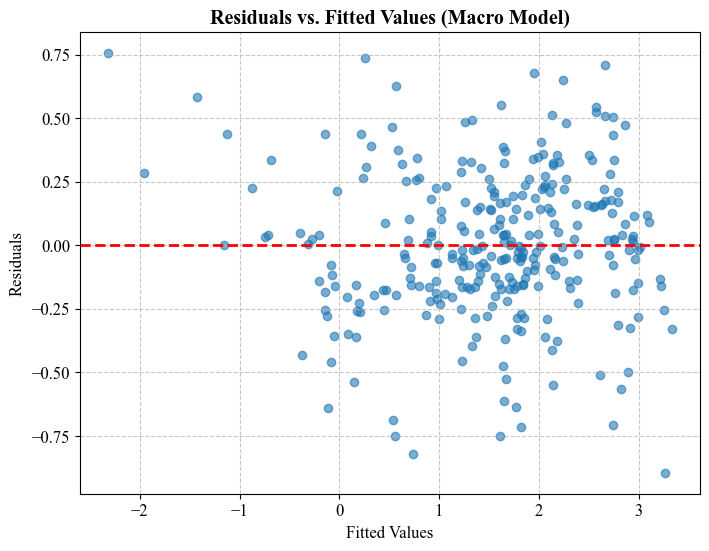

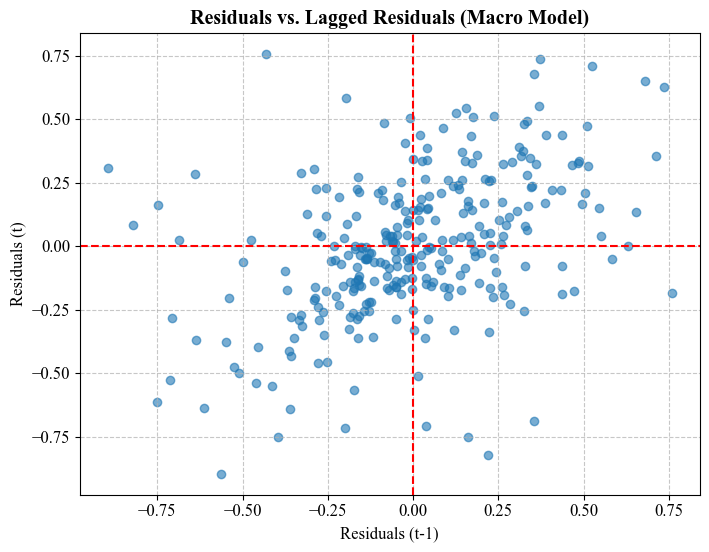

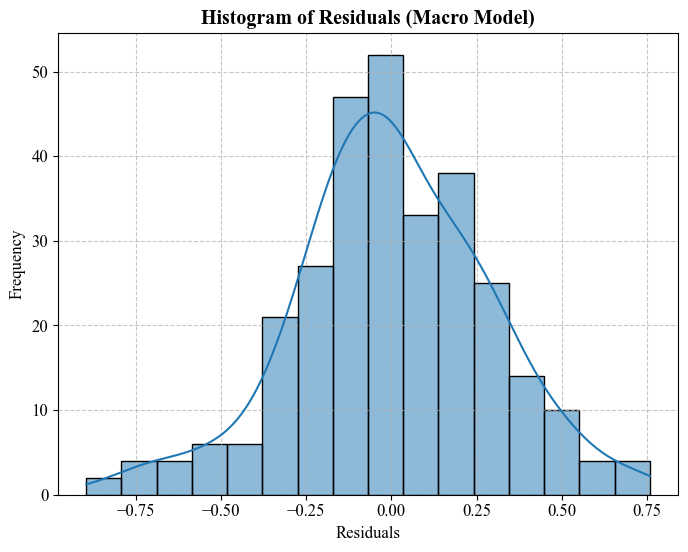

<Figure size 800x600 with 0 Axes>

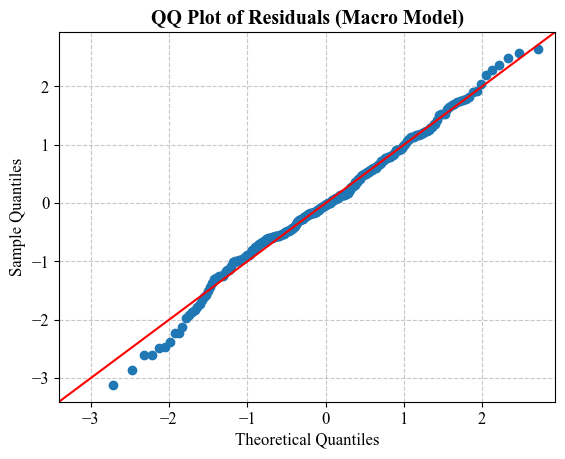


Diagnostics for Baseline Model

Robust Standard Errors (HC3):
                            OLS Regression Results                            
Dep. Variable:        logit_satislife   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 22 Jul 2025   Prob (F-statistic):                nan
Time:                        09:48:55   Log-Likelihood:                -73.230
No. Observations:                 297   AIC:                             222.5
Df Residuals:                     259   BIC:                             362.8
Df Model:                          37                                         
Covariance Type:                  HC3                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------

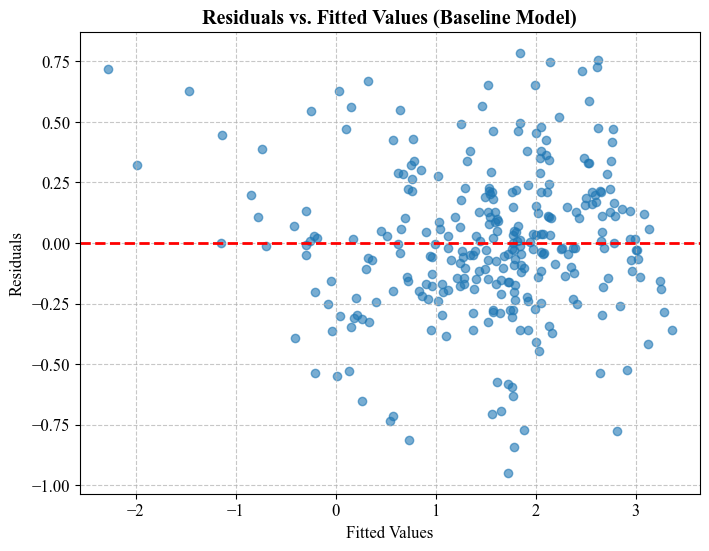

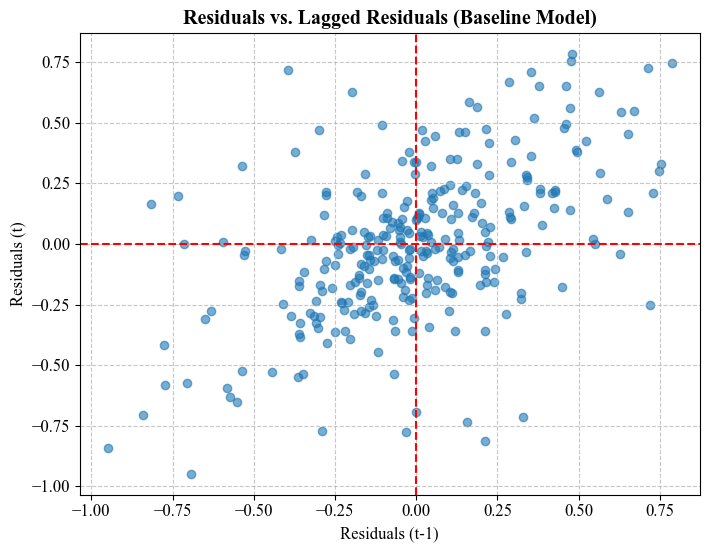

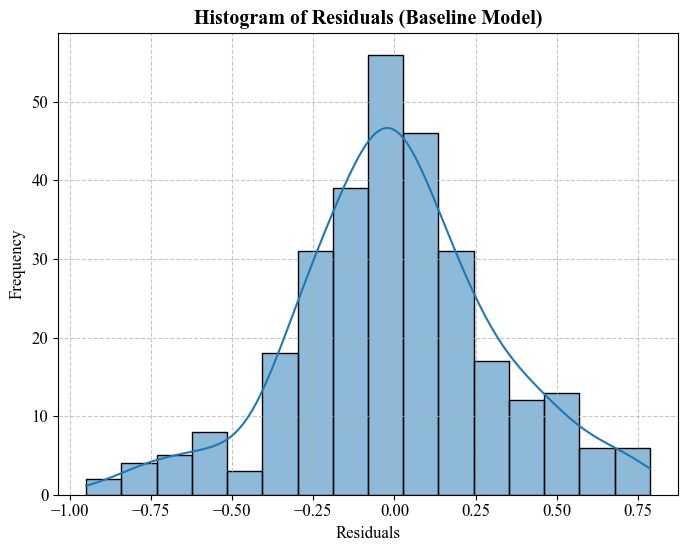

<Figure size 800x600 with 0 Axes>

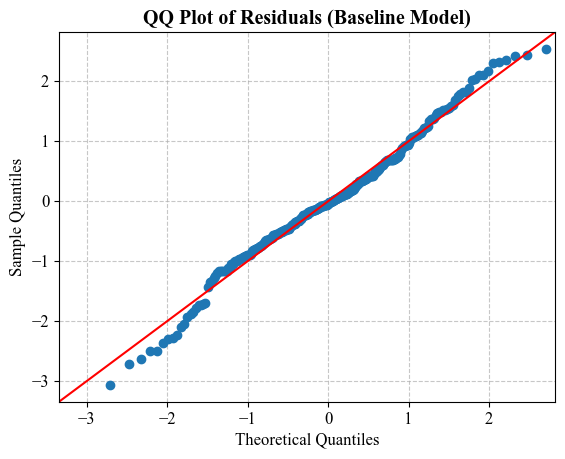

In [26]:
def diagnose_model(model, model_name=""):
    print(f"\n{'='*30}\nDiagnostics for {model_name}\n{'='*30}")

    # Robust standard errors (HC3)
    robust_model = model.get_robustcov_results(cov_type='HC3')
    print(f"\nRobust Standard Errors (HC3):")
    print(robust_model.summary())

    # Robust standard errors (Newey-West)
    robust_model_hac = model.get_robustcov_results(cov_type='HAC', maxlags=1)
    print(f"\nRobust Standard Errors (HAC, Newey-West):")
    print(robust_model_hac.summary())

    residuals = model.resid
    exog = model.model.exog

    # Breusch-Pagan test
    try:
        exog_bp = sm.add_constant(exog, has_constant='add')  
        _, pval, _, _ = het_breuschpagan(residuals, exog_bp)
        print(f"\nBreusch-Pagan p-value: {pval:.4f} {'(Heteroskedasticity!)' if pval <= 0.05 else '(OK)'}")
    except Exception as e:
        print(f"\nBreusch-Pagan test not executable: {e}")

    # Durbin-Watson test
    dw_stat = durbin_watson(residuals)
    print(f"Durbin-Watson: {dw_stat:.4f} → {'positive autocorrelation!' if dw_stat < 1.5 else ('negative autocorrelation!' if dw_stat > 2.5 else 'OK')}")

    # Jarque-Bera test
    jb_test = jarque_bera(residuals)
    print(f"\nJarque-Bera Test:")
    print(f"  Test statistic: {jb_test[0]:.4f}")
    print(f"  p-value: {jb_test[1]:.4f} → {'normally distributed' if jb_test[1] > 0.05 else 'not normally distributed'}")
    print(f"  Skewness: {jb_test[2]:.4f}")
    print(f"  Kurtosis: {jb_test[3]:.4f}")

    # VIF 
    exog_names = model.model.exog_names
    real_predictors = [name for name in exog_names if not name.startswith('C(') and name != 'Intercept']
    if len(real_predictors) > 1:
        cols_idx = [exog_names.index(name) for name in real_predictors]
        X_real = exog[:, cols_idx]
        vif_values = [variance_inflation_factor(X_real, i) for i in range(X_real.shape[1])]
        vif_df = pd.DataFrame({'Variable': real_predictors, 'VIF': vif_values})
        print("\nVariance Inflation Factors (VIF):")
        print(vif_df)
    else:
        print("\nVIF: Only one predictor – multicollinearity cannot be assessed.")

    # Residual plots
    fitted_values = model.fittedvalues
    residuals_series = pd.Series(residuals)

    # Residuals vs. Fitted Values
    plt.figure(figsize=(8, 6))
    plt.scatter(fitted_values, residuals, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--', linewidth=2)
    plt.title(f'Residuals vs. Fitted Values ({model_name})', fontdict={'weight': 'bold'})
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    # Residuals vs. Lagged Residuals
    residuals_lagged = residuals_series.shift(1)
    plt.figure(figsize=(8, 6))
    plt.scatter(residuals_lagged[1:], residuals_series[1:], alpha=0.6)
    plt.title(f'Residuals vs. Lagged Residuals ({model_name})', fontdict={'weight': 'bold'})
    plt.xlabel('Residuals (t-1)')
    plt.ylabel('Residuals (t)')
    plt.axhline(0, color='red', linestyle='--')
    plt.axvline(0, color='red', linestyle='--')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    # Histogram of Residuals
    plt.figure(figsize=(8, 6))
    sns.histplot(residuals, kde=True)
    plt.title(f'Histogram of Residuals ({model_name})', fontdict={'weight': 'bold'})
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    # QQ Plot
    plt.figure(figsize=(8, 6))
    sm.qqplot(residuals, line='45', fit=True)
    plt.title(f'QQ Plot of Residuals ({model_name})', fontdict={'weight': 'bold'})
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

diagnose_model(model_macro_no_intercept, model_name="Macro Model")
diagnose_model(model_baseline_no_intercept, model_name="Baseline Model")


# 5. Descriptive statistics of lagged macroeconomic control variables

In [27]:
macro_vars = ["unemployment_rate_lag1", "hicp_lag1", "gdp_per_capita_lag1"]
macro_desc = df_model_lagged_clean[macro_vars].describe().T

macro_desc["Median"] = df_model_lagged_clean[macro_vars].median()
macro_desc["75%"] = df_model_lagged_clean[macro_vars].quantile(0.75)

macro_desc = macro_desc.rename(columns={
    "count": "N", "mean": "Mean", "std": "SD",
    "min": "Min", "max": "Max"
})
macro_desc = macro_desc[["N", "Mean", "SD", "Min", "Median", "75%", "Max"]].round(2)

# Anzeige im Notebook im LaTeX-Format
latex_code = macro_desc.to_latex(
    caption="Descriptive statistics of lagged macroeconomic control variables",
    label="tab:macro_controls_descriptives",
    index=True,
    column_format="lrrrrrrr",
    escape=False,
    position="htbp"
)

display(Markdown(f"```latex\n{latex_code}\n```"))

/var/folders/rm/h2m1f6bj155_vxg0qyjhrj1h0000gn/T/ipykernel_14129/27239001.py:14: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_code = macro_desc.to_latex(


```latex
\begin{table}[htbp]
\centering
\caption{Descriptive statistics of lagged macroeconomic control variables}
\label{tab:macro_controls_descriptives}
\begin{tabular}{lrrrrrrr}
\toprule
{} &      N &      Mean &        SD &       Min &    Median &       75% &       Max \\
\midrule
unemployment_rate_lag1 &  297.0 &    226.07 &   1518.23 &      2.93 &      7.67 &     10.07 &   11398.0 \\
hicp_lag1              &  297.0 &      1.57 &      1.44 &     -2.10 &      1.60 &      2.50 &       6.4 \\
gdp_per_capita_lag1    &  297.0 &  35698.42 &  20211.97 &  13140.00 &  34360.00 &  42460.00 &  109090.0 \\
\bottomrule
\end{tabular}
\end{table}

```